### Student Information
Name:

Student ID:

GitHub ID:

Kaggle name:

Kaggle private scoreboard snapshot:

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [1]:
import torch
import random

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)

balance = True
val = True # Split validation of not
val_size = 0.1

### Data prepare

In [2]:
import pandas as pd
import os

data_path = "dataset/"
df_data = pd.read_json(os.path.join(data_path, "tweets_DM.json"), lines=True)
df_data["_source"][0]

{'tweet': {'hashtags': ['Snapchat'],
  'tweet_id': '0x376b20',
  'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}}

In [3]:
df_data.head()

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets


In [4]:
df_source = pd.json_normalize(df_data["_source"])

In [5]:
df_source.head()

,tweet.hashtags,tweet.tweet_id,tweet.text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is s..."


In [6]:
df_data = pd.concat([df_data, df_source], axis=1)
df_data = df_data.drop(columns=["_source"])

In [7]:
df_data.head()

,_score,_index,_crawldate,_type,tweet.hashtags,tweet.tweet_id,tweet.text
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s..."


In [8]:
df_data = df_data.rename(columns={"tweet.tweet_id": "tweet_id"})
df_data = df_data.rename(columns={"tweet.text": "text"})
df_data.drop(
    columns={"_type", "_score", "tweet.hashtags", "_score", "_index", "_crawldate"},
    inplace=True,
)

In [9]:
df_data.head()

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."


In [10]:
df_identification = pd.read_csv(os.path.join(data_path, "data_identification.csv"))

In [11]:
df_data = pd.merge(df_data, df_identification, on="tweet_id")

In [12]:
df_data.head()

,tweet_id,text,identification
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train
2,0x28b412,"Confident of your obedience, I write to you, k...",test
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test


In [13]:
df_test = df_data[df_data["identification"] == "test"]

In [14]:
df_emotion = pd.read_csv(os.path.join(data_path, "emotion.csv"))

In [15]:
df_emotion.head()

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


In [16]:
df_data = pd.merge(df_data, df_emotion, on="tweet_id")

In [17]:
df_data.head()

,tweet_id,text,identification,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation


In [18]:
df_train = df_data[df_data["identification"] == "train"]

In [19]:
df_train.head()

,tweet_id,text,identification,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,Still waiting on those supplies Liscus. <LH>,train,anticipation


In [20]:
df_test.head()

,tweet_id,text,identification
2,0x28b412,"Confident of your obedience, I write to you, k...",test
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test
9,0x218443,When do you have enough ? When are you satisfi...,test
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test
33,0x26289a,"In these tough times, who do YOU turn to as yo...",test


In [21]:
len(df_test)

411972

In [22]:
df_test.reset_index(drop=True, inplace=True)
len(df_test)

411972

In [23]:
df_train["text"].duplicated().sum()

np.int64(3785)

In [24]:
df_train.drop_duplicates(subset="text", keep="first", inplace=True)

In [25]:
df_train["text"].duplicated().sum()

np.int64(0)

In [26]:
import matplotlib.pyplot as plt


def plot_distribution(df, column="emotion"):
    datas = df.groupby(column).size()
    ax = datas.plot(kind="bar", legend=False)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height()}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
        )

    plt.show()

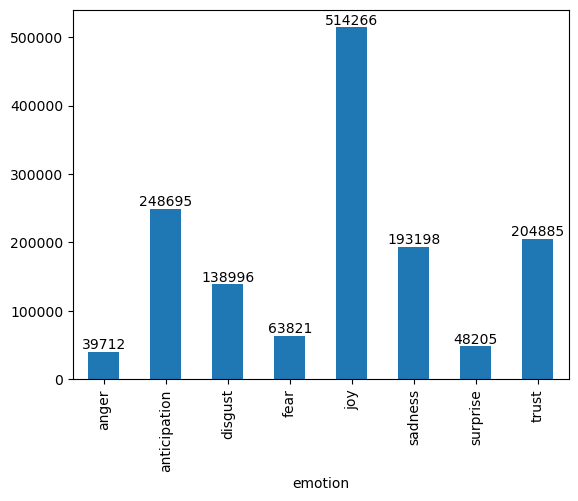

In [27]:
plot_distribution(df_train)

In [28]:
if val:
    df_val = df_train.sample(frac=val_size, random_state=seed)
    df_train = df_train.drop(df_val.index)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

In [ ]:
# df_train = df_train[df_train["emotion"] != "joy"]

In [29]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

if balance:
    X = df_train["text"]
    y = df_train["emotion"]

    upper_bound = 300000
    lower_bound = 0

    oversample_strategy = {}
    for label in y.unique():
        current_count = (y == label).sum()
        if current_count < lower_bound:
            oversample_strategy[label] = lower_bound
        else:
            oversample_strategy[label] = (
                current_count  # Keep as is if already more than 200,000
            )

    oversampler = RandomOverSampler(
        sampling_strategy=oversample_strategy, random_state=seed
    )
    X_oversampled, y_oversampled = oversampler.fit_resample(X.to_frame(), y)

    # Step 2: Convert the oversampled dataset to a DataFrame for further processing
    df_oversampled = pd.concat([X_oversampled, y_oversampled], axis=1)
    df_oversampled.columns = ["text", "emotion"]

    # Step 3: Undersample Classes Above 200,000
    undersample_strategy = {}
    for label in df_oversampled["emotion"].unique():
        current_count = (df_oversampled["emotion"] == label).sum()
        if current_count > upper_bound:
            undersample_strategy[label] = 96971
        else:
            undersample_strategy[label] = (
                current_count  # Keep as is if already 200,000 or below
            )

    undersampler = RandomUnderSampler(
        sampling_strategy=undersample_strategy, random_state=seed
    )
    X_balanced, y_balanced = undersampler.fit_resample(
        df_oversampled[["text"]], df_oversampled["emotion"]
    )

    # Step 4: Create the final resampled DataFrame
    df_balanced = pd.concat([X_balanced, y_balanced], axis=1)
    df_balanced.columns = ["text", "emotion"]

    # Step 5: Verify the new distribution
    print(df_balanced["emotion"].value_counts())

emotion
anticipation    223808
trust           184476
sadness         173740
disgust         124985
joy              96971
fear             57522
surprise         43543
anger            35730
Name: count, dtype: int64


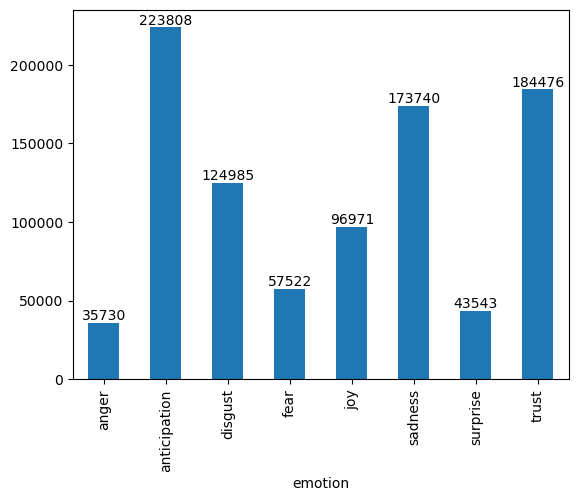

In [30]:
if balance:
    df_train = df_balanced
    plot_distribution(df_train)

In [31]:
df_sample = df_train.groupby("emotion", group_keys=False).apply(lambda x: x.sample(n=7))

/tmp/ipykernel_2175047/645112662.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df_train.groupby("emotion", group_keys=False).apply(lambda x: x.sample(n=7))


In [32]:
# sample = []
# for emotion in df_sample["emotion"].unique():
#     sample.append(
#         {
#             f"{emotion}": df_sample[df_sample["emotion"] == emotion][
#                 ["text", "emotion"]
#             ].to_dict(orient="records")
#         }
#     )
# sample = sample[0]

In [33]:
# sample["anger"]

In [34]:
print(df_train["text"].apply(type).value_counts())

text
<class 'str'>    940775
Name: count, dtype: int64


In [35]:
import pandas as pd
import re

def clean_text(text):
    # text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\S+", "", text)
    # text = re.sub(r"#\S+", "", text)
    # text = re.sub(r"\n", "", text)
    # text = re.sub(r"RT", "", text)
    # text = re.sub(r"  ", " ", text)
    return text

df_train["text"] = df_train["text"].astype(str).apply(clean_text)
if val:
    df_val["text"] = df_val["text"].astype(str).apply(clean_text)
df_test["text"] = df_test["text"].astype(str).apply(clean_text)


In [36]:
print(df_train["text"].apply(type).value_counts())

text
<class 'str'>    940775
Name: count, dtype: int64


In [37]:
nan_rows = df_train[df_train["text"].isna()]
print("Rows with NaN values:")
print(nan_rows)

empty_rows = df_train[df_train["text"].str.strip() == ""]
print("Rows with empty text:")
print(empty_rows)

Rows with NaN values:
Empty DataFrame
Columns: [text, emotion]
Index: []
Rows with empty text:
Empty DataFrame
Columns: [text, emotion]
Index: []


In [38]:
df_train = df_train.dropna(subset=["text"])
if val:
    df_val = df_val.dropna(subset=["text"])
df_test = df_test.dropna(subset=["text"])

df_train = df_train[df_train["text"].str.strip() != ""]
if val:
    df_val = df_val[df_val["text"].str.strip() != ""]
df_test = df_test[df_test["text"].str.strip() != ""]


In [39]:
nan_rows = df_train[df_train["text"].isna()]
print("Rows with NaN values:")
print(nan_rows)

empty_rows = df_train[df_train["text"].str.strip() == ""]
print("Rows with empty text:")
print(empty_rows)


Rows with NaN values:
Empty DataFrame
Columns: [text, emotion]
Index: []
Rows with empty text:
Empty DataFrame
Columns: [text, emotion]
Index: []


In [40]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(df_train["emotion"])

df_train["label"] = le.transform(df_train["emotion"])
if val:
    df_val["label"] = le.transform(df_val["emotion"])

In [41]:
df_train.to_csv(os.path.join(data_path, "train.csv"))
if val:
    df_val.to_csv(os.path.join(data_path, "val.csv"))
df_test.to_csv(os.path.join(data_path, "test.csv"))

### Training

In [42]:
import pandas as pd
import os
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "dataset/"
df_train = pd.read_csv(os.path.join(data_path, "train.csv"))
df_val = pd.read_csv(os.path.join(data_path, "val.csv"))
df_test = pd.read_csv(os.path.join(data_path, "test.csv"))

In [44]:
lr = 2e-5
batch_size = 64
epochs = 10
warmup_proportion = 0.1
patience = 3
grad_clip = 1.0
lora = False
weighted_loss = False
val = True
model_name = "FacebookAI/roberta-large"

In [45]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType



tokenizer = RobertaTokenizer.from_pretrained(model_name, cache_dir="cache/")

model = RobertaForSequenceClassification.from_pretrained(
    model_name, num_labels=len(df_train["label"].unique()), cache_dir="cache/"
)


if lora:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        task_type=TaskType.SEQ_CLS,
    )
    model = get_peft_model(model, lora_config)

    for name, param in model.named_parameters():
        if "lora" not in name:
            param.requires_grad = False

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
from torch.utils.data import Dataset, DataLoader


class EmotionDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.text = df["text"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        item = {"text": self.text[idx], "label": self.labels[idx]}
        return item

In [47]:
def collate_fn(batch):
    inputs = tokenizer(
        [x["text"] for x in batch],
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt",
    )
    inputs = inputs.to(device)
    labels = torch.tensor([x["label"] for x in batch], dtype=torch.long)
    labels = labels.to(device)
    return inputs, labels

In [48]:
import torch


class EmotionClassifier(torch.nn.Module):
    def __init__(self, model, num_emotions=8):
        super(EmotionClassifier, self).__init__()
        self.model = model
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_emotions)

    def forward(self, input_ids, attention_mask,token_type_ids=None):
        outputs = self.model(
            input_ids=input_ids, attention_mask=attention_mask
        )
        logits = outputs.logits
        logits = self.dropout(logits)
        
        return logits

In [49]:
train_dataset = EmotionDataset(df_train)
dl_train = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
validation_dataset = EmotionDataset(df_val)
dl_validation = DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

In [50]:
for batch in dl_train:
    print(batch)
    break

({'input_ids': tensor([[    0,  1801,   101,  ...,     1,     1,     1],
        [    0, 42337, 28814,  ...,     1,     1,     1],
        [    0,  6179,   109,  ...,     1,     1,     1],
        ...,
        [    0,  1559,   274,  ...,     1,     1,     1],
        [    0, 35634, 28696,  ...,     1,     1,     1],
        [    0, 33877,  4845,  ...,     1,     1,     1]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}, tensor([5, 7, 1, 0, 2, 7, 1, 3, 3, 7, 3, 1, 5, 1, 0, 2, 1, 7, 5, 2, 2, 2, 2, 1,
        5, 3, 1, 1, 2, 1, 5, 7, 1, 7, 2, 7, 4, 7, 2, 0, 3, 1, 0, 4, 5, 1, 1, 2,
        1, 2, 6, 7, 3, 1, 2, 6, 5, 5, 1, 1, 5, 7, 1, 1], device='cuda:0'))


In [51]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Calculate the cross entropy loss for each instance
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Compute the probability of the correct class (ground truth)
        pt = torch.exp(-ce_loss)
        
        # Focal Loss computation
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [52]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionClassifier(model).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

if lora:
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Original total parameters: {total_params}")
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters after LoRA: {trainable_params}")

if weighted_loss:
    alpha = 0.5
    gamma = 2
    loss_fn = FocalLoss(alpha=alpha, gamma=gamma).to(device)
else:
    loss_fn = CrossEntropyLoss().to(device)

In [53]:
# import torch
# import torch.optim as optim
# from torch.nn import CrossEntropyLoss

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = EmotionClassifier(model).to(device)
# optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
# loss_fn = CrossEntropyLoss().to(device)

# checkpoint_path = "model/model_epoch_3_state_dict.ckpt"  # path to the state dict checkpoint

# model.load_state_dict(torch.load(checkpoint_path))

# optimizer_path = "optimizer_epoch_3_state_dict.ckpt"  # assuming you have saved it
# if optimizer_path:
#     optimizer.load_state_dict(torch.load(optimizer_path))

# epochs = 8
# start = 4

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassRecall,
)

# Initialize metrics (update num_classes based on your dataset)
num_classes = len(df_train["label"].unique())  # Replace with the number of emotion classes
accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
f1_score = MulticlassF1Score(num_classes=num_classes).to(device)
precision = MulticlassPrecision(num_classes=num_classes).to(device)
recall = MulticlassRecall(num_classes=num_classes).to(device)

# Set up optimizer and learning rate scheduler with warm-up
total_steps = len(dl_train) * epochs
warmup_steps = int(warmup_proportion * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps
)

# Lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

train_steps = []  # Keeps track of steps for plotting
val_steps = []    # Keeps track of validation steps for plotting

step = 0
best_f1_score = 0.0  # Initialize to keep track of the best validation F1 score

for epoch in range(epochs):
    model.train()
    total_loss = 0
    pbar = tqdm(dl_train, desc=f"Epoch {epoch + 1}")
    for batch in pbar:
        # Extract inputs and labels from batch
        inputs, labels = batch

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        # Update metrics
        predictions = torch.argmax(outputs, dim=-1)
        accuracy.update(predictions, labels)
        f1_score.update(predictions, labels)
        precision.update(predictions, labels)
        recall.update(predictions, labels)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        # Update learning rate scheduler
        scheduler.step()

        if step % 10 == 0:
            train_steps.append(step)
            train_losses.append(loss.item())
            train_accuracies.append(accuracy.compute().item())
            train_f1_scores.append(f1_score.compute().item())

        # Display progress
        pbar.set_postfix({"loss": total_loss / (step + 1)})

        step += 1

    print(f"Training loss: {train_losses[-1]}")
    print(f"Training Accuracy: {train_accuracies[-1]}")
    print(f"Training F1 Score: {train_f1_scores[-1]}")
    print(f"Training Precision: {precision.compute().item()}")
    print(f"Training Recall: {recall.compute().item()}")

    # Reset metrics for next epoch
    accuracy.reset()
    f1_score.reset()
    precision.reset()
    recall.reset()

    if val:
        # Validation phase
        model.eval()
        total_loss = 0
        pbar = tqdm(dl_validation, desc=f"Epoch {epoch + 1} Validation")
        with torch.no_grad():
            for batch in pbar:
                inputs, labels = batch

                outputs = model(**inputs)
                loss = loss_fn(outputs, labels)
                total_loss += loss.item()

                # Update metrics
                predictions = torch.argmax(outputs, dim=-1)
                accuracy.update(predictions, labels)
                f1_score.update(predictions, labels)
                precision.update(predictions, labels)
                recall.update(predictions, labels)

        val_steps.append(step)
        val_losses.append(total_loss / len(dl_validation))
        val_accuracies.append(accuracy.compute().item())
        val_f1 = f1_score.compute().item()
        val_f1_scores.append(val_f1)

        print(f"Validation loss: {val_losses[-1]}")
        print(f"Validation Accuracy: {val_accuracies[-1]}")
        print(f"Validation F1 Score: {val_f1}")
        print(f"Validation Precision: {precision.compute().item()}")
        print(f"Validation Recall: {recall.compute().item()}")

        # Early stopping mechanism
        if epoch == 0:
            best_loss = total_loss
            best_f1_score = val_f1
            patience_counter = 0
        else:
            if total_loss < best_loss or val_f1 > best_f1_score:
                # Save model checkpoint if validation metrics improve
                best_loss = min(best_loss, total_loss)
                best_f1_score = max(best_f1_score, val_f1)
                patience_counter = 0
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, f'model/checkpoint{epoch+1}.pth')
            else:
                patience_counter += 1
                if patience_counter == patience:
                    print("Early stopping")
                    break

        # Reset metrics for next epoch
        accuracy.reset()
        f1_score.reset()
        precision.reset()
        recall.reset()

Epoch 1:  56%|█████▌    | 8193/14700 [30:10<21:32,  5.04it/s, loss=1.46]  

In [ ]:

# Plotting the metrics
plt.figure(figsize=(14, 10))

# Plot training and validation loss
plt.subplot(2, 1, 1)
plt.plot(train_steps, train_losses, label="Training Loss")
if val:
    plt.plot(val_steps, val_losses, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy and F1 score on the same chart
plt.subplot(2, 1, 2)
plt.plot(train_steps, train_accuracies, label="Training Accuracy", linestyle='-')
plt.plot(train_steps, train_f1_scores, label="Training F1 Score", linestyle='--')
if val:
    plt.plot(val_steps, val_accuracies, label="Validation Accuracy", linestyle='-')
    plt.plot(val_steps, val_f1_scores, label="Validation F1 Score", linestyle='--')
plt.xlabel("Steps")
plt.ylabel("Score")
plt.title("Training and Validation Accuracy & F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

#### Testing

In [ ]:
load_model = "model/model_epoch_4.ckpt"

In [ ]:
from torch.utils.data import Dataset


class TestEmotionDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.text = df["text"].tolist()
        self.id = df["tweet_id"].tolist()

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        item = {"text": self.text[idx], "id": self.id[idx]}
        return item


def collate_fn(batch):
    inputs = tokenizer(
        [x["text"] for x in batch], return_tensors="pt", padding=True, truncation=True
    )
    inputs = inputs.to(device)
    ids = [x["id"] for x in batch]
    return inputs, ids


test_dataset = TestEmotionDataset(df_test)
dl_test = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(load_model, map_location=device).to(device)

In [ ]:
from tqdm import tqdm

model.eval()
with torch.no_grad():
    tweet_ids = []
    emotion = []
    pbar = tqdm(dl_test, desc="Predicting")
    for inputs, ids in pbar:
        logits = model(**inputs)
        preds = torch.argmax(logits, dim=1)
        tweet_ids.extend(ids)
        emotion.extend(preds.tolist())


In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(df_train["emotion"])

emotion = le.inverse_transform(emotion)
submit = pd.DataFrame({"id": tweet_ids, "emotion": emotion})
submit.to_csv("submission.csv", index=False)

In [ ]:
submit.head(10)